In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler , StandardScaler
import pickle

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder


In [90]:
df_filtered = pd.read_csv('df_filtered.csv')

In [91]:
le = LabelEncoder()
df_filtered['Cross Reference Type_encoded'] = le.fit_transform(df_filtered['Cross Reference Type'])

# Display the mapping
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3}


In [92]:
df_filtered["Cross Reference Type"].value_counts()

Cross Reference Type
D    808455
C    159451
B     36926
A     18360
Name: count, dtype: int64

In [93]:
# Get dummies (one-hot encoding) for both columns
supplier_package_encoded = pd.get_dummies(df_filtered['Supplier_Package'], prefix='pkg')
supplier_package_comp_encoded = pd.get_dummies(df_filtered['Supplier_Package_comp'], prefix='pkg_comp')

# Drop original columns and concatenate one-hot encoded columns
df_filtered = pd.concat([
    df_filtered.drop(['Supplier_Package', 'Supplier_Package_comp'], axis=1),
    supplier_package_encoded,
    supplier_package_comp_encoded
], axis=1)


In [111]:
columns_1 = ['Maximum Input Offset Voltage', 'Maximum Single Supply Voltage','Minimum Single Supply Voltage', 'Number of Channels per Chip' , 'Typical Gain Bandwidth Product'] + supplier_package_encoded.columns.tolist()
columns_2 = [ 'Maximum Input Offset Voltage_comp',
       'Maximum Single Supply Voltage_comp',
       'Minimum Single Supply Voltage_comp',
       'Number of Channels per Chip_comp',
       'Typical Gain Bandwidth Product_comp'] + supplier_package_comp_encoded.columns.tolist()
# categorical_columns=['MPN', 'MANUFACTURER','Supplier_Package','MPN_comp',
#        'MANUFACTURER_comp','Supplier_Package_comp']


In [98]:
from sklearn.model_selection import train_test_split
def split_dataframe(df, train_percent=0.8, validate_percent=0.1, test_percent=0.1, random_state=42, stratify_col="Cross Reference Type"):
    assert train_percent + validate_percent + test_percent == 1, "Split percentages must sum to 1."

    # First split: Train and Temp (Validate + Test)
    train_df, temp_df = train_test_split(
        df,
        test_size=(validate_percent + test_percent),
        stratify=df[stratify_col],
        random_state=random_state
    )
    
    # Calculate the proportion of validation and test from the Temp split
    if validate_percent==0:
        return train_df, temp_df
    test_size = test_percent / (validate_percent + test_percent)
    
    # Second split: Validate and Test
    validate_df, test_df = train_test_split(
        temp_df,
        test_size=test_size,
        stratify=temp_df[stratify_col],
        random_state=random_state
    )
    
    return train_df, validate_df, test_df

In [99]:
train_df,  test_df = split_dataframe(df_filtered,train_percent=0.7,validate_percent=0,test_percent=0.3,random_state=1772341)
print(train_df["Cross Reference Type"].value_counts(normalize=False))

print(test_df["Cross Reference Type"].value_counts(normalize=True))

Cross Reference Type
D    565918
C    111616
B     25848
A     12852
Name: count, dtype: int64
Cross Reference Type
D    0.790131
C    0.155836
B    0.036090
A    0.017944
Name: proportion, dtype: float64


In [100]:
def fix_classes(df,random_state=1772341, n=12852):
    class_A = df[train_df["Cross Reference Type"] == "A"]
    class_B = df[train_df["Cross Reference Type"].isin(["B"])]
    class_C = df[train_df["Cross Reference Type"].isin(["C"])]
    class_D = df[train_df["Cross Reference Type"].isin(["D"])]
    class_B_downsampled = class_B.sample(n=n, random_state=random_state)
    class_C_downsampled = class_C.sample(n=n,random_state=random_state)
    class_A_oversampled = class_A.sample(n=n,random_state=random_state)
    class_D_downsampled = class_D.sample(n=n,random_state=random_state)
    return pd.concat([class_A_oversampled, class_B_downsampled, class_C_downsampled,class_D_downsampled],axis=  0)

In [101]:
train_df = fix_classes(train_df)

In [102]:
train_df["Cross Reference Type"].value_counts()

Cross Reference Type
A    12852
B    12852
C    12852
D    12852
Name: count, dtype: int64

In [122]:
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

class CustomVectorDataset(Dataset):
    def __init__(self, dataframe, vector1_columns, vector2_columns, target_column):
        """
        Args:
            dataframe (pd.DataFrame): The DataFrame containing the data.
            vector1_columns (list): List of column names for the first vector.
            vector2_columns (list): List of column names for the second vector.
            target_column (str): The column name for the target value.
            categorical_columns (list): List of column names that are categorical.
        """
        self.dataframe = dataframe.copy()
        self.vector1_columns = vector1_columns
        self.vector2_columns = vector2_columns
        self.target_column = target_column

        
        # Label encode categorical columns
        # Convert columns to tensors
        self.vector1 = torch.tensor(self.dataframe[self.vector1_columns].values.astype(np.float32), dtype=torch.float32)
        self.vector2 = torch.tensor(self.dataframe[self.vector2_columns].values.astype(np.float32), dtype=torch.float32)
        self.target = torch.tensor(self.dataframe[self.target_column].values, dtype=torch.long)  # Changed to long for classification

    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        vector1 = self.vector1[idx]
        vector2 = self.vector2[idx]
        target = self.target[idx]  # Already a LongTensor and 1D
        return vector1, vector2, target

In [182]:
class CNNClassifier(nn.Module):
    def __init__(self, input_dim, num_classes=4):
        super(CNNClassifier, self).__init__()
        combined_dim = input_dim * 2  # Concatenated input dimensions

        self.features = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(p=0.1),
            
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(p=0.1),
        )

        self.classifier = nn.Sequential(
            nn.Linear(32 * (combined_dim // 4), 64),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(64, num_classes)
        )

    def forward(self, input1, input2):
        combined = torch.cat((input1, input2), dim=1).unsqueeze(1)  # Shape: (batch_size, 1, combined_dim)
        x = self.features(combined)
        x = x.view(x.size(0), -1)  # Flatten
        out = self.classifier(x)
        return out

In [171]:
import torch
import torch.nn as nn

class FullyConnectedClassifier(nn.Module):
    def __init__(self, input_dim, num_classes=4):
        super(FullyConnectedClassifier, self).__init__()
        combined_dim = input_dim * 2  # Concatenated input dimensions

        self.feature_extractor = nn.Sequential(
            nn.Linear(combined_dim, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(p=0.01),
            # nn.Linear(32, 16),
            # nn.BatchNorm1d(16),
            # nn.ReLU(),
            # nn.Dropout(p=0.05),
        )

        self.classifier = nn.Sequential(
            nn.Linear(16, 8),
            nn.BatchNorm1d(8),
            nn.ReLU(),

            nn.Linear(8, num_classes)
        )

    def forward(self, input1, input2):
        combined = torch.cat((input1, input2), dim=1)
        features = self.feature_extractor(combined)
        out = self.classifier(features)
        return out

In [124]:
train_df.columns

Index(['Cross Reference Type', 'MPN', 'MANUFACTURER',
       'Maximum Input Offset Voltage', 'Maximum Single Supply Voltage',
       'Minimum Single Supply Voltage', 'Number of Channels per Chip',
       'Typical Gain Bandwidth Product', 'MPN_comp', 'MANUFACTURER_comp',
       ...
       'pkg_comp_WSON EP', 'pkg_comp_Wafer', 'pkg_comp_X1SON',
       'pkg_comp_X2QFN', 'pkg_comp_X2SON EP', 'pkg_comp_XCEPT',
       'pkg_comp_uMAX', 'pkg_comp_uMAX EP', 'pkg_comp_uSMD', 'pkg_comp_uSOIC'],
      dtype='object', length=310)

In [136]:
batch_size = 4

In [146]:
torch.manual_seed(1772341)
dataset_train = CustomVectorDataset(train_df,columns_1,columns_2, 'Cross Reference Type_encoded')
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
# Test
dataset_test = CustomVectorDataset(test_df, columns_1, columns_2, 'Cross Reference Type_encoded')
dataloader_test = DataLoader(dataset_test, batch_size=64, shuffle=False)
# Validation
# dataset_validate = CustomVectorDataset(validate_df, columns_1, columns_2, 'Closeness', categorical_columns=categorical_columns)
# dataloader_validate = DataLoader(dataset_validate, batch_size=batch_size, shuffle=False)

In [138]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [139]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_df["Cross Reference Type_encoded"]), y=train_df["Cross Reference Type_encoded"])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


In [140]:
np.unique(train_df["Cross Reference Type_encoded"])

array([0, 1, 2, 3])

In [141]:
class_weights

tensor([1., 1., 1., 1.], device='cuda:0')

In [142]:
# Inspect a batch from the training DataLoader
for batch in dataloader_train:
    input1, input2, targets = batch
    print("Input1 shape:", input1.shape)   # Expected: [batch_size, input_dim]
    print("Input2 shape:", input2.shape)   # Expected: [batch_size, input_dim]
    print("Targets shape:", targets.shape) # Expected: [batch_size]
    print("Targets dtype:", targets.dtype) # Expected: torch.long
    break

Input1 shape: torch.Size([4, 152])
Input2 shape: torch.Size([4, 152])
Targets shape: torch.Size([4])
Targets dtype: torch.int64


In [183]:
from tqdm import tqdm
input_dim = len(columns_1)
# model = FullyConnectedClassifier(input_dim).to(device)
model = CNNClassifier(input_dim).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
optimizer = optim.Adadelta(model.parameters(), lr=1, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',           # Reduce LR when the validation loss stops decreasing
    factor=0.5,          # Multiply LR by 0.5 when plateauing (less aggressive than 0.1)
    patience=1,          # Number of epochs with no improvement after which LR will be reduced
    verbose=True,        # Print message when LR is reduced
    min_lr=1e-6         # Minimum LR value
)

c:\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [190]:
num_epochs = 10
train_loss_history = []
val_loss_history = []
train_accuracy_history = []
val_accuracy_history = []
best_val_loss = float('inf')
for epoch in range(num_epochs):
    # -----------------------------
    # 5.1. Training Phase
    # -----------------------------
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for vec1, vec2, target in tqdm(dataloader_train, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        vec1, vec2, target = vec1.to(device), vec2.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(vec1, vec2)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * vec1.size(0)  # Accumulate loss
        
        # Calculate training accuracy
        _, predicted = torch.max(output, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()
    
    epoch_train_loss = running_loss / len(dataloader_train.dataset)
    train_loss_history.append(epoch_train_loss)
    
    epoch_train_accuracy = correct_train / total_train
    train_accuracy_history.append(epoch_train_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_accuracy:.4f}")
    
    # -----------------------------
    # 5.2. Validation Phase
    # -----------------------------
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for vec1, vec2, target in tqdm(dataloader_test, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            vec1, vec2, target = vec1.to(device), vec2.to(device), target.to(device)
            
            output = model(vec1, vec2)
            loss = criterion(output, target)
            val_running_loss += loss.item() * vec1.size(0)  # Accumulate loss
            
            # Calculate validation accuracy
            _, predicted = torch.max(output, 1)
            total_val += target.size(0)
            correct_val += (predicted == target).sum().item()
    
    epoch_val_loss = val_running_loss / len(dataloader_test.dataset)
    val_loss_history.append(epoch_val_loss)
    
    epoch_val_accuracy = correct_val / total_val
    val_accuracy_history.append(epoch_val_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.4f}")
    
    # -----------------------------
    # 5.3. Step the Scheduler
    # -----------------------------
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), "DL-classifier.pth")
        print(f"  -> Best model saved with Validation Loss: {best_val_loss:.4f}")
    
    scheduler.step(epoch_val_loss)

Epoch 1/10 - Training: 100%|██████████| 12852/12852 [01:03<00:00, 201.22it/s]


Epoch [1/10], Training Loss: 0.5978, Training Accuracy: 0.7377


Epoch 1/10 - Validation: 100%|██████████| 4797/4797 [00:11<00:00, 427.65it/s]


Epoch [1/10], Validation Loss: 0.4083, Validation Accuracy: 0.8421
  -> Best model saved with Validation Loss: 0.4083


Epoch 2/10 - Training: 100%|██████████| 12852/12852 [01:04<00:00, 198.45it/s]


Epoch [2/10], Training Loss: 0.5972, Training Accuracy: 0.7358


Epoch 2/10 - Validation: 100%|██████████| 4797/4797 [00:10<00:00, 442.82it/s]


Epoch [2/10], Validation Loss: 0.3975, Validation Accuracy: 0.8497
  -> Best model saved with Validation Loss: 0.3975


Epoch 3/10 - Training: 100%|██████████| 12852/12852 [01:00<00:00, 211.75it/s]


Epoch [3/10], Training Loss: 0.5941, Training Accuracy: 0.7375


Epoch 3/10 - Validation: 100%|██████████| 4797/4797 [00:10<00:00, 445.06it/s]


Epoch [3/10], Validation Loss: 0.4127, Validation Accuracy: 0.8415


Epoch 4/10 - Training: 100%|██████████| 12852/12852 [01:00<00:00, 211.87it/s]


Epoch [4/10], Training Loss: 0.5981, Training Accuracy: 0.7360


Epoch 4/10 - Validation: 100%|██████████| 4797/4797 [00:10<00:00, 448.11it/s]


Epoch [4/10], Validation Loss: 0.3980, Validation Accuracy: 0.8451


Epoch 5/10 - Training: 100%|██████████| 12852/12852 [01:00<00:00, 211.55it/s]


Epoch [5/10], Training Loss: 0.5930, Training Accuracy: 0.7371


Epoch 5/10 - Validation: 100%|██████████| 4797/4797 [00:11<00:00, 422.50it/s]


Epoch [5/10], Validation Loss: 0.4063, Validation Accuracy: 0.8428


Epoch 6/10 - Training: 100%|██████████| 12852/12852 [01:05<00:00, 194.79it/s]


Epoch [6/10], Training Loss: 0.5956, Training Accuracy: 0.7331


Epoch 6/10 - Validation: 100%|██████████| 4797/4797 [00:11<00:00, 420.53it/s]


Epoch [6/10], Validation Loss: 0.4018, Validation Accuracy: 0.8459


Epoch 7/10 - Training: 100%|██████████| 12852/12852 [01:05<00:00, 195.22it/s]


Epoch [7/10], Training Loss: 0.5956, Training Accuracy: 0.7388


Epoch 7/10 - Validation: 100%|██████████| 4797/4797 [00:11<00:00, 435.63it/s]


Epoch [7/10], Validation Loss: 0.4029, Validation Accuracy: 0.8430


Epoch 8/10 - Training: 100%|██████████| 12852/12852 [01:02<00:00, 205.04it/s]


Epoch [8/10], Training Loss: 0.5906, Training Accuracy: 0.7367


Epoch 8/10 - Validation: 100%|██████████| 4797/4797 [00:10<00:00, 451.43it/s]


Epoch [8/10], Validation Loss: 0.3981, Validation Accuracy: 0.8456


Epoch 9/10 - Training: 100%|██████████| 12852/12852 [01:02<00:00, 205.26it/s]


Epoch [9/10], Training Loss: 0.5942, Training Accuracy: 0.7365


Epoch 9/10 - Validation: 100%|██████████| 4797/4797 [00:10<00:00, 457.19it/s]


Epoch [9/10], Validation Loss: 0.3984, Validation Accuracy: 0.8452


Epoch 10/10 - Training: 100%|██████████| 12852/12852 [01:02<00:00, 204.28it/s]


Epoch [10/10], Training Loss: 0.5990, Training Accuracy: 0.7355


Epoch 10/10 - Validation: 100%|██████████| 4797/4797 [00:11<00:00, 432.77it/s]

Epoch [10/10], Validation Loss: 0.4019, Validation Accuracy: 0.8444


In [185]:
train_hist_loss_adadelta= []
val_hist_loss_adadelta = []
train_hist_acc_adadelta = []
val_hist_acc_adadelta = []

In [188]:

train_hist_loss_adadelta.extend(train_loss_history)
val_hist_loss_adadelta.extend(val_loss_history)
train_hist_acc_adadelta.extend(train_accuracy_history)
val_hist_acc_adadelta.extend(val_accuracy_history)


In [178]:
train_hist_loss_adam= []
val_hist_loss_adam = []
train_hist_acc_adam = []
val_hist_acc_adam = []

In [161]:
train_hist_loss_adam= []
val_hist_loss_adam = []
train_hist_acc_adam = []
val_hist_acc_adam = []
train_hist_loss_adam.extend(train_loss_history)
val_hist_loss_adam.extend(val_loss_history)
train_hist_acc_adam.extend(train_accuracy_history)
val_hist_acc_adam.extend(val_accuracy_history)


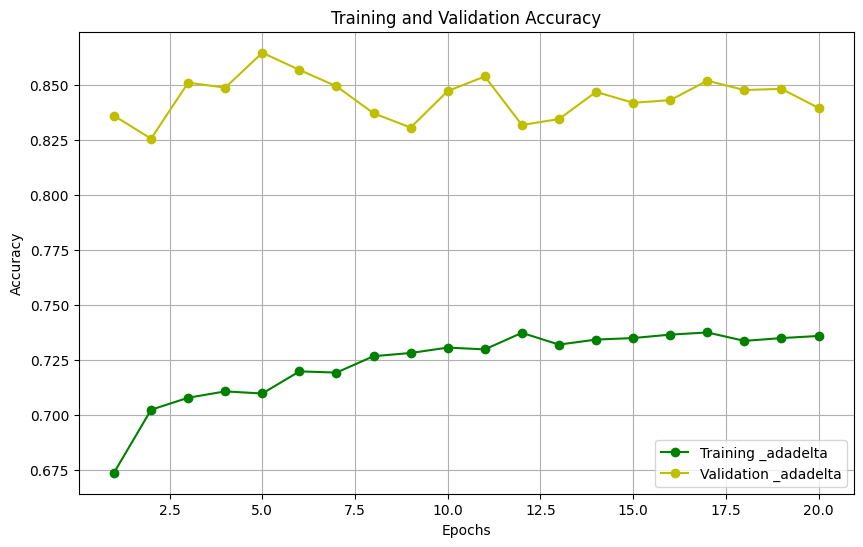

In [189]:




epochs = range(1,len(train_hist_acc_adadelta)+1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_hist_acc_adadelta, 'go-', label='Training _adadelta')
plt.plot(epochs, val_hist_acc_adadelta, 'yo-', label='Validation _adadelta')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

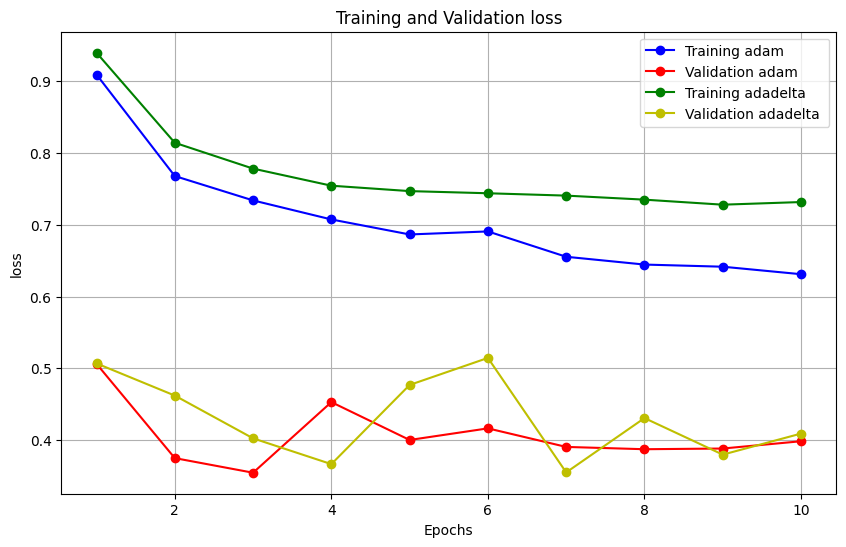

In [170]:
epochs = range(1,len(train_hist_loss_adam)+1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_hist_loss_adam, 'bo-', label='Training adam ')
plt.plot(epochs, val_hist_loss_adam, 'ro-', label='Validation adam ')
plt.plot(epochs, train_hist_loss_adadelta, 'go-', label='Training adadelta ')
plt.plot(epochs, val_hist_loss_adadelta, 'yo-', label='Validation adadelta ')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.show()

Evaluating on Test Set: 100%|██████████| 6395/6395 [00:15<00:00, 412.31it/s]


Test Set Classification Report:
              precision    recall  f1-score   support

           A       0.03      0.28      0.05      3672
           B       0.04      0.00      0.00      7385
           C       0.16      0.08      0.10     31890
           D       0.82      0.76      0.79    161692

    accuracy                           0.62    204639
   macro avg       0.26      0.28      0.24    204639
weighted avg       0.68      0.62      0.64    204639



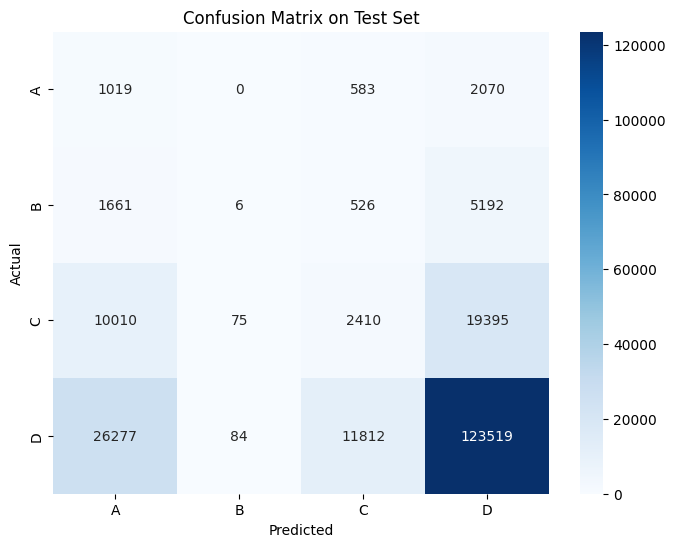

In [107]:
from sklearn.metrics import classification_report, confusion_matrix

# model.load_state_dict(torch.load(best_model_path))
model.to(device)

model.eval()
all_test_targets = []
all_test_predictions = []

with torch.no_grad():
    for vec1, vec2, target in tqdm(dataloader_test, desc="Evaluating on Test Set"):
        vec1, vec2, target = vec1.to(device), vec2.to(device), target.to(device)
        output = model(vec1, vec2)
        _, predicted = torch.max(output, 1)
        all_test_targets.extend(target.cpu().numpy())
        all_test_predictions.extend(predicted.cpu().numpy())

# Generate Classification Report
test_class_report = classification_report(all_test_targets, all_test_predictions, target_names=le.classes_, zero_division=0)
print("Test Set Classification Report:")
print(test_class_report)

# Generate Confusion Matrix
conf_mat = confusion_matrix(all_test_targets, all_test_predictions, labels=range(len(le.classes_)))
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()